# Tutorial 1 – SPaiNN Database

This tutorial describes how data needs to be prepared and stored in order to be used with **SPaiNN**. 
If you are using SHARC to generate data or already have an existing database for SchNarc this step is simple and straight forward. 
If you generate your data with other tools you might have to create a custom script to convert the data in the correct form. For latter you find a description on how data needs to be prepared in this tutorial.

The data pipeline of **SpaiNN** mainly consists of DatabaseUtils and involves the creation of a database using the ``GenerateDB`` class or the conversion of existing databases (e.g., SchNarc database) using the ``ConvertDB`` class.

## Convert an existing database

The following example demonstrates how to convert an existing database into a **SPaiNN** database.
For this purpose, we use the database obtained for the methylenimmonium cation ($\mathsf{CH_2NH_2^+}$), which was *e.g.* used in combination with the SchNarc sofware package.

<img src="./img/properties_shape.png" width='450'>

The sample SchNarc database (``schnarc_ch2nh2+.db``) contains energies, forces, non-adiabatic coupling, dipoles, and spin-orbit couplings of 99 geometries of the methylenimmonium cation.
The respective properties are stored in form of an Atomic Simulation Environment (ASE) databse.

In the following way, one can perform the conversion of the databases.

**1. Import Required Packages**

To start, you need to import necessary packages. This can be achieved by including the following lines of code:

In [1]:
import os, sys
from ase.db import connect

import spainn
from spainn.asetools import ConvertDB

**2. Converting the Database**

To convert an existing database, you employ the `convert` function from the `ConvertDB` module of **SPaiNN**. This function brings the property entries of the existing databse in the shapes as needed in the SPaiNN data pipeline. For instance, the forces must be of shape $N_{atoms}\times N_{states}\times 3$. 
Moreover, the nonadiabatic couplings can be smoothed when converting the database, *i.e.*, the original nonadiabatic coupling entries are divided by the energy difference of the respective coupled states. Here’s how to perform this step:

In [2]:
%rm ./data/spainn_ch2nh2+.db
# Path to existing and to-be-created database
oldDB = os.path.join(os.getcwd(), 'data', 'schnarc_ch2nh2+.db')
newDB = os.path.join(os.getcwd(), 'data', 'spainn_ch2nh2+.db')

convDB = ConvertDB()
convDB.convert(olddb=oldDB, newdb=newDB, copy_metadata=True, smooth_nacs=True)

INFO:spainn.asetools.convert_db:Converting /home/carolin/Documents/00_software/SPaiNN/tutorials/data/schnarc_ch2nh2+.db into /home/carolin/Documents/00_software/SPaiNN/tutorials/data/spainn_ch2nh2+.db
INFO:spainn.asetools.convert_db:/home/carolin/Documents/00_software/SPaiNN/tutorials/data/schnarc_ch2nh2+.db has 99 entries
INFO:spainn.asetools.convert_db:/home/carolin/Documents/00_software/SPaiNN/tutorials/data/schnarc_ch2nh2+.db keys: energy socs forces nacs dipoles


**3. Updating Metadata**

Finally, you update the metadata information of the database. Noteworthy, for now we have just kept the metadata information of the original **SchNarc** database. However, we have to add a dictionary of units (properties and atomic coordinates) and states (number of singlet, doublet, and triplet states) as metadata. This is required at later stages in the **SPaiNN** data pipeline. The following code snippet demonstrates how to add this information during the database conversion:

In [3]:
# Current metadata
db_new = connect(newDB)
metadata_ori = db_new.metadata
metadata_ori

{'n_singlets': 3,
 'n_triplets': 0,
 'states': 'S S S ',
 'phasecorrected': False,
 'ReferenceMethod': 'MR-CISD(6,4)/aug-cc-pVDZ, program: COLUMBUS',
 'atomrefs': {}}

In [4]:
# Dictionary of units and how to add it to existing metadata

unit_dict = {
   '_distance_unit': 'Bohr',
   '_property_unit_dict': {'energy': 'Hartree', 'forces': 'Hartree/Bohr', 'nacs': '1', 'smooth_nacs': '1'},
}

db_new.metadata = {**metadata_ori, **unit_dict}
db_new.metadata

{'n_singlets': 3,
 'n_triplets': 0,
 'states': 'S S S ',
 'phasecorrected': False,
 'ReferenceMethod': 'MR-CISD(6,4)/aug-cc-pVDZ, program: COLUMBUS',
 'atomrefs': {},
 '_distance_unit': 'Bohr',
 '_property_unit_dict': {'energy': 'Hartree',
  'forces': 'Hartree/Bohr',
  'nacs': '1',
  'smooth_nacs': '1'}}

## Overview of the dataset (energies)

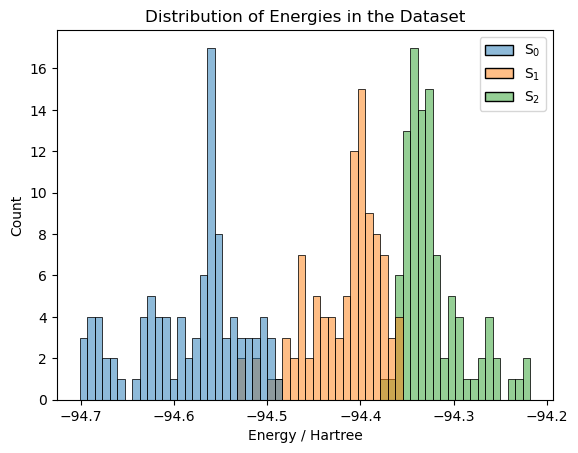

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

db_spainn = connect(newDB)

table_data = [
    {
        'Molecule': db_spainn.get_atoms(mols+1).get_chemical_formula(),
        'S$_0$': db_spainn.get(mols+1).data['energy'][0][0],
        'S$_1$': db_spainn.get(mols+1).data['energy'][0][1],
        'S$_2$': db_spainn.get(mols+1).data['energy'][0][2]
    }
    for mols in range(len(db_spainn))
]

df = pd.DataFrame(table_data)

# Create a combined histogram plot
sns.histplot(data=df, bins=60, kde=False, multiple='layer')

# Set labels and title
plt.xlabel('Energy / Hartree')
plt.ylabel('Count')
plt.title('Distribution of Energies in the Dataset')

# Show the plot
plt.show()